In [ ]:
import pandas as pd

# Load the datasets
train_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv'
dev_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_dev.tsv'

# Load TSV files into DataFrames
train_data = pd.read_csv(train_file_path, sep='\t')
dev_data = pd.read_csv(dev_file_path, sep='\t')

# Display the first few rows of each dataset
train_data.head(), dev_data.head()

(             event_name            tweet_id              image_id  \
 0  california_wildfires  917791291823591425  917791291823591425_0   
 1  california_wildfires  917791291823591425  917791291823591425_1   
 2  california_wildfires  917793137925459968  917793137925459968_0   
 3  california_wildfires  917793137925459968  917793137925459968_1   
 4  california_wildfires  917793137925459968  917793137925459968_2   
 
                                           tweet_text  \
 0  RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...   
 1  RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...   
 2  RT @KAKEnews: California wildfires destroy mor...   
 3  RT @KAKEnews: California wildfires destroy mor...   
 4  RT @KAKEnews: California wildfires destroy mor...   
 
                                                image            label  \
 0  data_image/california_wildfires/10_10_2017/917...      informative   
 1  data_image/california_wildfires/10_10_2017/917...  not_informative   
 2  data_ima

C:\Users\Aman\AppData\Local\Temp\ipykernel_21824\467928120.py:156: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/2:   0%|          | 0/451 [00:00<?, ?it/s]C:\Users\Aman\AppData\Local\Temp\ipykernel_21824\467928120.py:174: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/2:  19%|█▉        | 85/451 [11:37<37:09,  6.09s/it]  c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/2: 100%|██████████| 451/451 [49:48<00:00,  6.63s/it]


Epoch 1/2, Train Loss: 188.5868, Train Accuracy: 82.08%, Validation Accuracy: 91.99%


Epoch 2/2: 100%|██████████| 451/451 [40:06<00:00,  5.34s/it]  


Epoch 2/2, Train Loss: 81.2718, Train Accuracy: 94.81%, Validation Accuracy: 93.77%


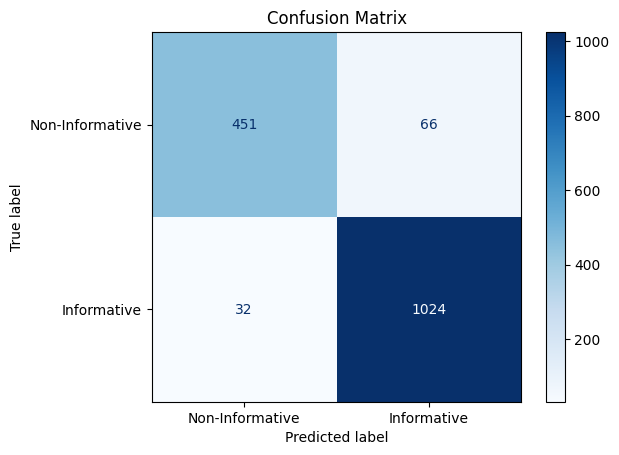

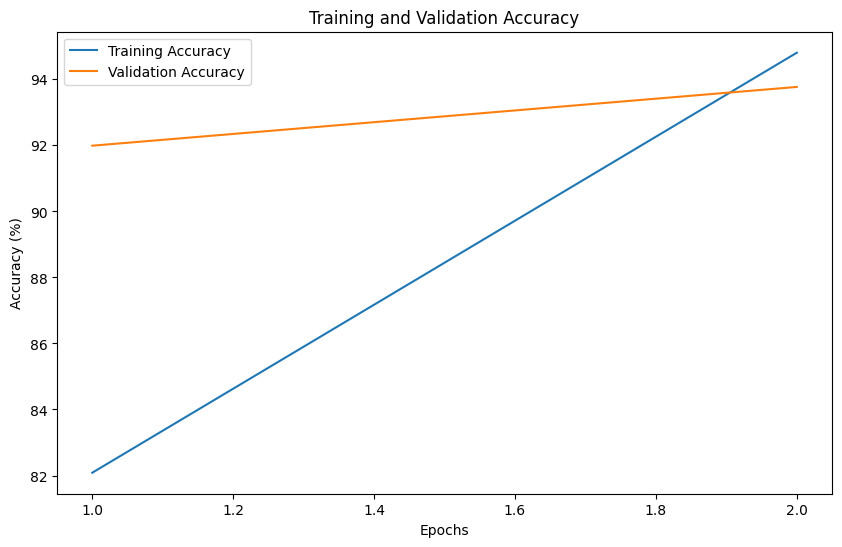

In [4]:
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# -------------------------------
# 1. Load Data and Filter Samples
# -------------------------------

train_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv'
dev_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_dev.tsv'

# Load TSV files into DataFrames
train_df = pd.read_csv(train_file_path, sep='\t')
dev_df = pd.read_csv(dev_file_path, sep='\t')

# Filter datasets to include only samples where 'label_text_image' is "Positive"
train_df_positive = train_df[train_df['label_text_image'] == 'Positive'].reset_index(drop=True)
dev_df_positive = dev_df[dev_df['label_text_image'] == 'Positive'].reset_index(drop=True)

# -------------------------------
# 2. Data Augmentation for Training Data
# -------------------------------

# Create augmented samples using image mixup and text concatenation
augmented_samples = []
for label in ["informative", "not_informative"]:
    group = train_df_positive[train_df_positive['label'] == label].reset_index(drop=True)
    # Pair consecutive samples; if odd number, the last sample is skipped
    for i in range(0, len(group) - 1, 2):
        augmented_sample = {
            "tweet_text": group.loc[i, "tweet_text"] + " " + group.loc[i+1, "tweet_text"],
            # Save the image paths from both samples for augmentation
            "image1": group.loc[i, "image"],
            "image2": group.loc[i+1, "image"],
            "label": label,
            "augmented": True  # flag to indicate this sample is augmented
        }
        augmented_samples.append(augmented_sample)

# Convert augmented samples to DataFrame and combine with original training data
augmented_df = pd.DataFrame(augmented_samples)
train_df_augmented = pd.concat([train_df_positive, augmented_df], ignore_index=True)

# -------------------------------
# 3. Define the Dataset Class
# -------------------------------

class MultimodalDataset(Dataset):
    def __init__(self, dataframe, image_dir, processor, max_length=77):
        self.data = dataframe
        self.image_dir = image_dir  # Ensure this is set to your image folder path
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        # Check if this sample is augmented
        if 'augmented' in row and row.get('augmented', False) == True:
            text = row['tweet_text']
            image_path1 = self.image_dir + row['image1']
            image_path2 = self.image_dir + row['image2']
            image1 = Image.open(image_path1).convert("RGB")
            image2 = Image.open(image_path2).convert("RGB")
            # Resize image2 to match image1 if necessary
            if image1.size != image2.size:
                image2 = image2.resize(image1.size)
            # Blend images with alpha=0.5 (i.e. mixup with λ=0.5)
            image = Image.blend(image1, image2, alpha=0.5)
        else:
            text = row['tweet_text']
            image_path = self.image_dir + row['image']
            image = Image.open(image_path).convert("RGB")
        
        # Convert label to numeric: 1 for informative, 0 for not_informative
        label = 1 if row['label'] == 'informative' else 0
        
        # Process text and image using CLIP processor
        inputs = self.processor(
            text=text,
            images=image,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_length
        )
        return inputs, torch.tensor(label)

# -------------------------------
# 4. Initialize CLIP Model and Processor
# -------------------------------

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

# -------------------------------
# 5. Create Datasets and Dataloaders
# -------------------------------

# Set your image directory (update this to your actual image folder path)
image_dir = ""

train_dataset = MultimodalDataset(train_df_augmented, image_dir, processor)
val_dataset = MultimodalDataset(dev_df_positive, image_dir, processor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# -------------------------------
# 6. Define the Multimodal Classifier
# -------------------------------

class MultimodalClassifier(nn.Module):
    def __init__(self, clip_model):
        super(MultimodalClassifier, self).__init__()
        self.clip_model = clip_model
        # Custom classification layer (input dimension is twice the CLIP projection dim)
        self.classifier = nn.Sequential(
            nn.Linear(clip_model.config.projection_dim * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # Output one logit for binary classification
        )

    def forward(self, inputs):
        # Extract text and image embeddings
        text_embeddings = self.clip_model.get_text_features(inputs['input_ids'].squeeze(1))
        image_embeddings = self.clip_model.get_image_features(inputs['pixel_values'])
        # Concatenate the embeddings
        combined_embeddings = torch.cat((text_embeddings, image_embeddings), dim=-1)
        # Classify the combined embeddings
        output = self.classifier(combined_embeddings)
        return output

model = MultimodalClassifier(clip_model)

# -------------------------------
# 7. Define Optimizer, Loss Function, and Training Loop
# -------------------------------

optimizer = optim.AdamW(model.parameters(), lr=1e-6)
loss_fn = nn.BCEWithLogitsLoss()

def train_model(model, train_loader, val_loader, optimizer, loss_fn, num_epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    scaler = torch.cuda.amp.GradScaler()

    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            # Squeeze extra dimension and move tensors to device
            inputs = {key: value.squeeze(1).to(device) for key, value in inputs.items()}
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = loss_fn(outputs.squeeze(1), labels.float())

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            predicted = (torch.sigmoid(outputs.squeeze(1)) > 0.5).long()
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

        train_accuracy = correct_preds / total_preds * 100
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_correct_preds = 0
        val_total_preds = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = {key: value.squeeze(1).to(device) for key, value in inputs.items()}
                labels = labels.to(device)

                outputs = model(inputs)
                predicted = (torch.sigmoid(outputs.squeeze(1)) > 0.5).long()

                val_correct_preds += (predicted == labels).sum().item()
                val_total_preds += labels.size(0)

                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        val_accuracy = val_correct_preds / val_total_preds * 100
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

    # Display confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                  display_labels=["Non-Informative", "Informative"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
    plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.show()

# -------------------------------
# 8. Train the Model
# -------------------------------

train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    num_epochs=2
)


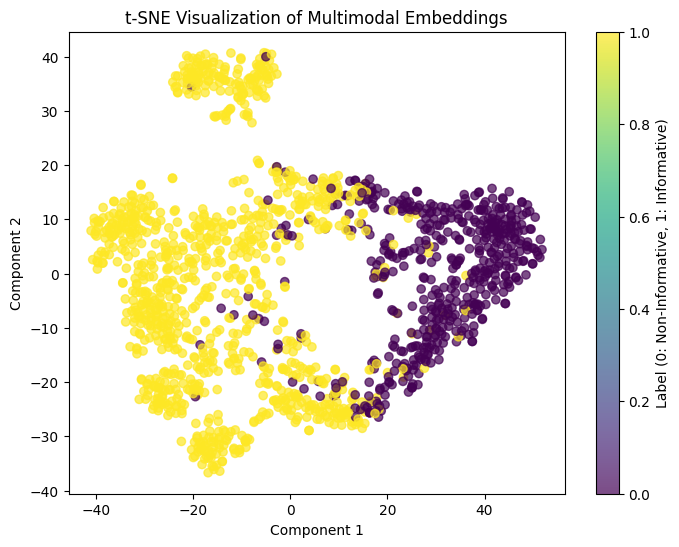

In [5]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

def visualize_tsne(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            # Move inputs and labels to device and remove extra batch dimensions
            inputs = {key: value.squeeze(1).to(device) for key, value in inputs.items()}
            labels = labels.to(device)

            # Extract text and image embeddings from the CLIP model
            text_embeddings = model.clip_model.get_text_features(inputs['input_ids'])
            image_embeddings = model.clip_model.get_image_features(inputs['pixel_values'])

            # Concatenate text and image embeddings
            combined_embeddings = torch.cat((text_embeddings, image_embeddings), dim=-1)
            all_embeddings.append(combined_embeddings.cpu())
            all_labels.append(labels.cpu())

    # Concatenate all batches
    all_embeddings = torch.cat(all_embeddings, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Perform t-SNE to reduce embeddings to 2 dimensions
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(all_embeddings.numpy())

    # Plot the 2D embeddings
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=all_labels.numpy(), cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Label (0: Non-Informative, 1: Informative)')
    plt.title("t-SNE Visualization of Multimodal Embeddings")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

# Example usage (ensure `model` and `val_loader` are defined and loaded with your data):
visualize_tsne(model, val_loader)


c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Test Accuracy: 92.63%
Precision: 0.9346
Recall: 0.9573
F1 Score: 0.9458


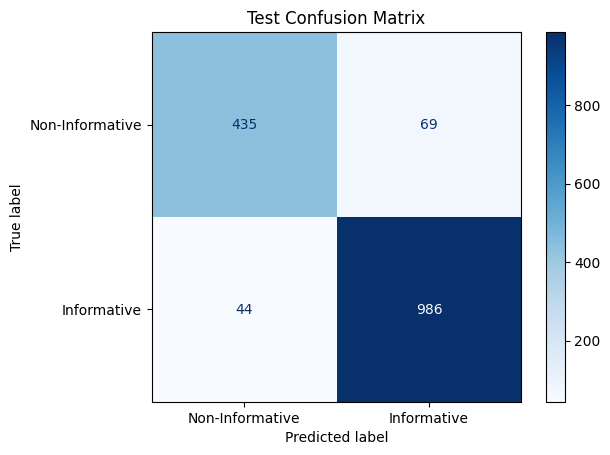

In [6]:
import pandas as pd
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Load and filter test data
test_df = pd.read_csv('crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_test.tsv', sep='\t')
test_df_positive = test_df[test_df['label_text_image'] == 'Positive'].reset_index(drop=True)

# Create test dataset and dataloader
test_dataset = MultimodalDataset(test_df_positive, image_dir, processor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model on test data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        # Squeeze extra dimensions and move to device
        inputs = {key: value.squeeze(1).to(device) for key, value in inputs.items()}
        labels = labels.to(device)
        outputs = model(inputs)
        predicted = (torch.sigmoid(outputs.squeeze(1)) > 0.5).long()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(all_labels, all_predictions) * 100
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print("Test Accuracy: {:.2f}%".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

# Display confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Informative", "Informative"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Test Confusion Matrix")
plt.show()
